# 목적

- 사전 학습된 koBert 모델 계열 활용
- **데이터를 새로 넣어 가중치 / 편향값 새로 계산 → 학습 진행 → 상당한 시간 소요 (성능 보장 X → 리스크가 있다)**
- epoch는 시간 관계상 1세대만 진행
  - 예산 시간 : 대략 4,300초 (GPU 기준)
    - 일일 무료기준 코랩에서는 10시간 정도 가능한 것으로 예측
- 데이터
  - 네이버 리뷰(한국어 말뭉치 공급 원소스에서 제공)
- 사용 준비
  - transformers
  - 토크나이저 / 모델
  ( 이 세가지 모델은 꼭 같이 다닌다)
  - 데이터 컨버팅 (필요할 시, tensorflow용도로 변경)

# 데이터 획득

- Korpora
  - **오픈소스 말뭉치**들의 다운로드와 **전처리 기능을 제공**하는 파이썬 라이브러리

In [1]:
!pip install Korpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 5.8 MB/s 
     |████████████████████████████████| 96 kB 6.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
from Korpora import Korpora
Korpora.corpus_list()  # corpus - 말뭉치

{'kcbert': 'beomi@github 님이 만드신 KcBERT 학습데이터',
 'korean_chatbot_data': 'songys@github 님이 만드신 챗봇 문답 데이터',
 'korean_hate_speech': '{inmoonlight,warnikchow,beomi}@github 님이 만드신 혐오댓글데이터',
 'korean_parallel_koen_news': 'jungyeul@github 님이 만드신 병렬 말뭉치',
 'korean_petitions': 'lovit@github 님이 만드신 2017.08 ~ 2019.03 청와대 청원데이터',
 'kornli': 'KakaoBrain 에서 제공하는 Natural Language Inference (NLI) 데이터',
 'korsts': 'KakaoBrain 에서 제공하는 Semantic Textual Similarity (STS) 데이터',
 'kowikitext': 'lovit@github 님이 만드신 wikitext 형식의 한국어 위키피디아 데이터',
 'namuwikitext': 'lovit@github 님이 만드신 wikitext 형식의 나무위키 데이터',
 'naver_changwon_ner': '네이버 + 창원대 NER shared task data',
 'nsmc': 'e9t@github 님이 만드신 Naver sentiment movie corpus v1.0',
 'question_pair': 'songys@github 님이 만드신 질문쌍(Paired Question v.2)',
 'modu_news': '국립국어원에서 만든 모두의 말뭉치: 뉴스 말뭉치',
 'modu_messenger': '국립국어원에서 만든 모두의 말뭉치: 메신저 말뭉치',
 'modu_mp': '국립국어원에서 만든 모두의 말뭉치: 형태 분석 말뭉치',
 'modu_ne': '국립국어원에서 만든 모두의 말뭉치: 개체명 분석 말뭉치',
 'modu_spoken': '국립국어원에서 만든 모두의 말뭉치: 구어 

In [3]:
# 'nsmc' : 'e9t@github님이 만드신 Naver sentiment movie corpus v.1.0'
# 네이버 리뷰 감성분류 데이터 (긍정/부정) 획득
corpus = Korpora.load('nsmc')
corpus


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:00, 69.7MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 92.2MB/s]


## 데이터 확인

In [4]:
# 훈련데이터 확인,  LabeledSentence 객체가 데이터 개수만큼 생성된 구조
type(corpus.train), corpus.train[0]

(Korpora.korpora.LabeledSentenceKorpusData,
 LabeledSentence(text='아 더빙.. 진짜 짜증나네요 목소리', label=0))

In [5]:
corpus.train[0].text, corpus.train[0].label

('아 더빙.. 진짜 짜증나네요 목소리', 0)

In [6]:
# 데이터를 모두 획득, # ()로 나오기 때문에 tuple
corpus.train.get_all_texts()[:2]

('아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나')

In [7]:
corpus.train.get_all_labels()[:2]

[0, 1]

In [8]:
import pandas as pd

In [9]:
# DF로 구성
train_df = pd.DataFrame()
test_df  = pd.DataFrame()

In [10]:
train_df['doc'] = corpus.train.get_all_texts()
train_df['label'] = corpus.train.get_all_labels()
train_df.head(2)

,doc,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1


In [11]:
test_df['doc']   = corpus.test.get_all_texts()
test_df['label'] = corpus.test.get_all_labels()
test_df.head(2)

,doc,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0


# 데이터 전처리 + EDA

In [12]:
# 75% 25%
train_df.shape, test_df.shape

((150000, 2), (50000, 2))

In [13]:
# 중복을 제거한 총 개수 → 중복된 리뷰가 존재
train_df.doc.nunique(), train_df.label.nunique(), train_df.label.unique()

(146183, 2, array([0, 1]))

In [14]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
# 리뷰 중복값 제거 
# train_df.drop_duplicates(subset='doc', inplace=True)
# or 
train_df.drop_duplicates(subset=['doc'], inplace=True)
# 기본 함수 처리시 문제 발생 → 텍스트 보정 작업 직접 필요 → 진행해보고 문제 발생시 교체하는 방안
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   doc     146183 non-null  object
 1   label   146183 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


0    73342
1    72841
Name: label, dtype: int64
50.17136055492089
49.82863944507911


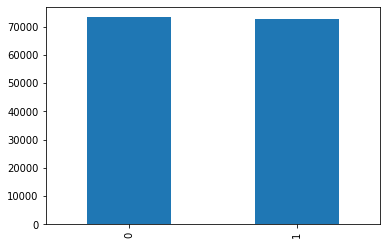

In [15]:
import matplotlib.pyplot as plt
# 긍정 / 부정의 데이터 비율
print( train_df.label.value_counts() )
print( train_df.label.value_counts()[0] / len(train_df.label) * 100  )
print( train_df.label.value_counts()[1] / len(train_df.label) * 100 )
train_df.label.value_counts().plot( kind='bar' )
plt.show()

In [16]:
# 결측치는 없어서 제거 하지 않는다
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   doc     146183 non-null  object
 1   label   146183 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [17]:
train_df.dropna(how='any')
train_df.isnull().values.any()

False

In [18]:
test_df.dropna(how='any')
test_df.isnull().values.any()

False

In [19]:
test_df.shape

(50000, 2)

# 모델 구축

- 자연어 처리 - 사전학습 된 모델 + 파인튜닝 진행

## 트랜스포머 설치

In [20]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 26.1 MB/s 
     |████████████████████████████████| 120 kB 12.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 


In [21]:
import transformers

transformers.__version__

'4.21.3'

## Tokenizer / Model 획득

- 허깅페이스에서 검색 후 사용
  - 한국형 bert 모델 원조
    - skt에서 개발한 koBert
    - https://huggingface.co/skt/kobert-base-v1
    - https://github.com/SKTBrain/KoBERT
  - koBert를 기반으로 나온 모델군들 중 선택
    - https://huggingface.co/klue/bert-base
    - https://github.com/KLUE-benchmark/KLUE
    - 활용
- Tokenizer
  - https://huggingface.co/docs/transformers/main_classes/tokenizer

In [22]:
# BertTokenizerFast 와 BertTokenizer 간에는 속도 차이만 존재한다(1.2~1.5)
from transformers import BertTokenizerFast

In [23]:
tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')

In [24]:
# 토크나이저 처리를 위해 형식 변경
X_train_data = train_df.doc.tolist()
X_train_data[:2]

['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나']

In [25]:
X_test_data = test_df.doc.tolist()

## 토큰화 처리

- 텍스트 → 수치화(사전화, 인덱스화, 임베딩, 패딩, 넘치는 글자 자르기 …)
- 모델에 학습할 데이터 사전 준비단계

In [26]:
# (리뷰 텍스트 말뭉치, 문장에서 특정 크기를 넘치는 텍스트는 제거하고(truncation) 부족한 부분은 채운다(padding))
# 버트 내부에 설정된 크기로 처리된다(벼롣 지정은 하지 않음)
X_train = tokenizer(X_train_data, truncation=True, padding=True )
X_test = tokenizer(X_test_data, truncation=True, padding=True )

In [27]:
X_train_data[0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [28]:
# 샘플 확인
X_train[0]

Encoding(num_tokens=142, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [29]:
'''
  - 스페셜 토큰(Special Token) : Bert라는 모델은 스페셜 토큰을 이용하여 문장을 인코딩한다
  - [CLS] : 2, 문장이 시작되었다는 시작 토큰 기호
  - [SEP] : 3, '문장이 끝나면 표시되는 토큰' 혹은 '첫 번째 문장과 두 번째 문장의 구분값으로도 사용'
  - [PAD] : 0, Padding, 전체 통일된 토큰 크기에서 부족한 부분은(문장의 길이가 작아서) 채울 때 사용
'''
print(len(X_train[0].tokens), X_train[0].tokens)

142 ['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

In [30]:
# 수치화된 표현 확인
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
# 문장을 구분한 값 , 첫 번째 문장은 0, 두 번째 문장은 1, ...
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
# attention_mask : 문장이면 1, 문장이 아니면 (Padding) 0
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [33]:
# 정답 데이터 리스트로 획득
y_train = train_df.label.tolist()
y_test = test_df.label.tolist()

## 토큰화된 데이터를 데이터 모델에서 학습하기 위해서 컨버전 진행

- koBert 계열은 기본적으로 torch로 개발되었음
- 텐서플로우(케라스)에서 활용하기 위해서는 컨버전이 필요

In [34]:
import tensorflow as tf

In [35]:
len(y_train), len(y_test)

(146183, 50000)

In [36]:
# 컨버전 (3분)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

In [37]:
# 학습에 사용할 데이터를 저장해서 나주엥 활용하는 것이 시간적 이득이 있다
# 각자 진행

## 사전 학습된 모델 획득

In [38]:
from transformers import TFBertForSequenceClassification
# 문장을 보고 긍정과 부정을 분류하는 것이 목적이므로, TFBertForSequenceClassification 선택
'''
 - klue/bert-base' : 사전 학습된 모델의 Hugging Face 레퍼지토리 주소({소유자}/{브런치})
 - num_labels=2 : 최종 분류되는 레이블의 개수 지정
 - from_pt=True : 텐서플로우 모델로 변화해 로드해달라는 설정값
'''
model = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 컴파일

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# 학습

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
'''
  - monitor : 조기학습 종료의 판단 기준이되는 지표값
  - min_delta : 전-후 값을 비교하여 해당 값보다 작으면 조기학습 종료가 발생
                      전후 값의 변화값을 비교하는 임계값
  - patience : 조기학습 종료 후 몇 번더 학습할 것이다 → EPOCH의 횟수
  - verbose : 로그 출력
'''
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta=0.001,
    patience=2,
)

In [43]:
# epoch는 1세대만 진행하는데(시간관계상), 실제로는 더 많은 훈련 시간이 필요함
# 검증용 데이터를 별도로 준비하지 않았고, 훈련용에서 split해서 사용할 계획도 없다
# test_dataset으로 검증용 데이터를 대체하겠다
with tf.device('/device:GPU:0'):
  model.fit(train_dataset.shuffle(1000).batch(32), epochs=1, batch_size=32, 
                  validation_data=test_dataset.shuffle(1000).batch(32),
                  callbacks=[earlyStopping])

4569/4569 [==============================] - 4257s 932ms/step - loss: 7.6509 - accuracy: 0.5017 - val_loss: 7.5698 - val_accuracy: 0.4964


In [ ]:
# 모델 테스트
model.evaluate(test_dataset.batch(16))

# 모델 저장

In [46]:
# 모델 저장
# config.json 저장, tf_model.h5
model.save_pretrained('/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model')

In [47]:
# tokenizer 저장
tokenizer.save_pretrained('/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model')

('/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model/tokenizer_config.json',
 '/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model/special_tokens_map.json',
 '/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model/vocab.txt',
 '/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model/added_tokens.json',
 '/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model/tokenizer.json')

# 모델 로드 ( 산출물, 서비스측에서 사용 )

In [50]:
from transformers import TextClassificationPipeline
from transformers import TFBertForSequenceClassification
from transformers import BertTokenizerFast

In [53]:
# 토크나이저 로드 → 저장된 경로를 지정
loadTokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model')

In [54]:
# 모델 로드 → 저장된 경로를 지정
loadModel = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model')

Some layers from the model checkpoint at /content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/빅데이터_딥러닝/Day04/pretrained_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without

In [55]:
# 텍스트 입력 → 토크나이저로부터 인코딩 → 예측수행 → 결과를 리턴 → TextClassificationPipeline
# 텍스트 입력 → 긍정 /부정 리턴
get_text_binary_clf = TextClassificationPipeline(
    tokenizer = loadTokenizer, # 토크나이저 지정
    model = loadModel, # 모델 지정
    framework = 'tf', # 구동 엔진 지정
    top_k = 1 # tip) 유사도 기능이 필요하면 지정 (huggingface.co/models 참조)
)

# 테스트

In [60]:
get_text_binary_clf( '마트보다 저렴하고 배송도  빨라요' )[0][0]['label']

'LABEL_0'

In [61]:
get_text_binary_clf( '마트보다 저렴하고 배송도  빨라요' )[0][0]['score']

0.667382538318634

In [62]:
get_text_binary_clf( '니케이 3일동안 4%올랐다가 겨우 2%빠니는게 걱정되냐 ㆍ어떤 등신은 오르지도 못하고 빠지고있다' )

[[{'label': 'LABEL_0', 'score': 0.667726457118988}]]